# Problem Statement

You are given the original and degraded versions of a few images. Your task is to write a GAN which can fix the degraded images.

Complete the function `fix` at the end of the "Evaluation" block so that it can take a degraded image, and return a fixed image (that looks as much like the original non-degraded version as possible). Read the doc-string of the fix function to see the format it expects.

Before submission, get this notebook in a state such that the `fix` function can directly be called on an image. Also, please make sure that 5 images are displayed in the result block. Without that, your submission will not be evaluated.

#Setup

## Intended Structure after Setup

Run the blocks in this section to get the following directory structure:
```
/content
│
└───rephrase-pubfig831
    │
    └───correct
    │   │
    │   └───train
    │   │   │
    │   │   └───Adam Sandler
    │   │   │   │   train__000001-000000.jpg
    │   │   │   │   train__000001-000001.jpg
    │   │   │   │   train__000001-000002.jpg
    │   │   │   │   ...
    │   │   │
    │   │   └───Alec Baldwin
    │   │   │   │   train__000002-000000.jpg
    │   │   │   │   train__000002-000001.jpg
    │   │   │   │   ...
    │   │   │
    │   │   └───Angelina Jolie
    │   │   │   │   train__000003-000000.jpg
    │   │   │   │   train__000003-000001.jpg
    │   │   │   │   ...
    │   │   │
    │   │   │ ...
    │   │
    │   └───test
    │       │
    │       └───Adam Sandler
    │       │   │   test__000001-000000.jpg
    │       │   │   test__000001-000001.jpg
    │       │   │   ...
    │       │
    │       └───Alec Baldwin
    │       │   │   test__000002-000000.jpg
    │       │   │   ...
    │       │
    │       └───Angelina Jolie
    │       │   │   test__000003-000000.jpg
    │       │   │   ...
    │       │
    │       │ ...
    │
    │
    └───degraded
        │   <Same directory structure as 'correct'>
```

Every image in the degraded directory is a degraded version of the image with the same name in the correct directory. e.g. `/content/rephrase-pubfig831/degraded/Adam Sandler/train__000001-000002.jpg` is the degraded version of `/content/rephrase-pubfig831/correct/Adam Sandler/train__000001-000002.jpg`

## Installation (pip etc)
Add any other installation commands you want to in this block.

In [ ]:
!pip install GPUtil
!pip install tqdm
!pip install gdown 
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install scipy==1.1.0



  Created wheel for GPUtil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=1150a17b71b584f15e23086cf6ec5e18ac5082b2931d3d1cfedace76473ccb8d
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built GPUtil
     |████████████████████████████████| 31.2MB 103kB/s 
ERROR: umap-learn 0.4.2 has requirement scipy>=1.3.1, but you'll have scipy 1.1.0 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement scipy==1.4.1; python_version >= "3", but you'll have scipy 1.1.0 which is incompatible.
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


## Downloading and Generating Dataset
Run this block only once. Do not modify it. Also, don't call the degrade function in your code anywhere. You should treat the degradation process as a black box.

In [ ]:
import os
from glob import glob

import cv2
import numpy as np
from tqdm import tqdm

def degrade(path: str) -> None:
    """Load image at `input_path`, distort and save as `output_path`"""
    SHIFT = 2
    image = cv2.imread(path)
    to_swap = np.random.choice([False, True], image.shape[:2], p=[.8, .2])
    swap_indices = np.where(to_swap[:-SHIFT] & ~to_swap[SHIFT:])
    swap_vals = image[swap_indices[0] + SHIFT, swap_indices[1]]
    image[swap_indices[0] + SHIFT, swap_indices[1]] = image[swap_indices]
    image[swap_indices] = swap_vals
    cv2.imwrite(path, image)

!wget http://briancbecker.com/files/downloads/pubfig83lfw/pubfig83lfw_raw_in_dirs.zip
!unzip -q pubfig83lfw_raw_in_dirs.zip
!rm pubfig83lfw_raw_in_dirs.zip
!mkdir pubfig831
!mv pubfig83lfw_raw_in_dirs pubfig831/correct
!rm -r pubfig831/correct/distract
!cp -r pubfig831/correct pubfig831/degraded

for image_path in tqdm(glob('pubfig831/degraded/*/*/*.jpg')):
  degrade(image_path)

--2020-05-19 07:22:58--  http://briancbecker.com/files/downloads/pubfig83lfw/pubfig83lfw_raw_in_dirs.zip
Resolving briancbecker.com (briancbecker.com)... 162.241.216.158
Connecting to briancbecker.com (briancbecker.com)|162.241.216.158|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 400247922 (382M) [application/zip]
Saving to: ‘pubfig83lfw_raw_in_dirs.zip’

pubfig83lfw_raw_in_ 100%[===================>] 381.71M  16.8MB/s    in 24s     

2020-05-19 07:23:23 (15.9 MB/s) - ‘pubfig83lfw_raw_in_dirs.zip’ saved [400247922/400247922]



100%|██████████| 13002/13002 [01:12<00:00, 179.59it/s]


# **Checking Free Memory**
This block is just so that you can have an idea of the resources you have at hand on the Google Collab system.

In [ ]:
import psutil
import humanize
import os
import GPUtil as GPU
gpu = GPU.getGPUs()[0]
process = psutil.Process(os.getpid())
print(f"Gen RAM: Free {humanize.naturalsize(psutil.virtual_memory().available)} | Proc size {humanize.naturalsize(process.memory_info().rss)}")
print(f"GPU RAM: Free {gpu.memoryFree:.0f}MB | Used {gpu.memoryUsed:.0f}MB | Util {gpu.memoryUtil*100:.0f}% | Total {gpu.memoryTotal:.0f}MB")

Gen RAM: Free 12.7 GB | Proc size 182.5 MB
GPU RAM: Free 11441MB | Used 0MB | Util 0% | Total 11441MB


# **Main Code**

## Data Loading

In [ ]:
def sample_images(data_dir, batch_size, correct_image_shape, degraded_image_shape):
    # Make a list of all images inside the data directory

    degraded_images = []
    correct_images = []

    all_dir = os.listdir(data_dir + "correct/train/")
    i = random.choice(all_dir)
    correct_data_dir = data_dir + "correct/train/"+i
    degraded_data_dir = data_dir  + "degraded/train/" + i
    all_images = os.listdir(correct_data_dir)
    for image in all_images[:batch_size]:

        print(correct_data_dir+'/'+ image)
        sample_correct = imread(correct_data_dir+'/'+ image, mode='RGB')
        sample_correct = sample_correct.astype(np.float32)
        sample_correct = skimage.transform.resize(sample_correct, correct_image_shape)
        correct_images.append(sample_correct)

        print(degraded_data_dir+'/'+ image)
        sample_degraded = imread(degraded_data_dir +'/' +  image, mode='RGB')
        sample_degraded = sample_degraded.astype(np.float32)
        sample_degraded = skimage.transform.resize(sample_degraded,degraded_image_shape)
        degraded_images.append(sample_degraded)
    return np.array(correct_images), np.array(degraded_images)

def save_images(degraded_image, original_image, correct_image, path):
    fig = plt.figure()
    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(correct_image)
    ax.axis("off")
    ax.set_title("Generated Images")
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(degraded_image)
    ax.axis("off")
    ax.set_title("Degraded Image")
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(original_image)
    ax.axis("off")
    ax.set_title("Correct Image")
    plt.savefig(path)

## Structure

### **Constants and Hyperparemeters**

In [ ]:
def res_block_gen(model, kernal_size, filters, strides):    
    gen = model
    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)
    # Using Parametric ReLU
    model = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(model)
    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)
    model = add([gen, model])
    return model
    
def build_vgg():
    input_shape = correct_image_shape
    vgg = VGG19(weights="imagenet")
    vgg.outputs = [vgg.layers[9].output]
    input_layer = Input(shape=input_shape)
    features = vgg(input_layer)
    model = Model(inputs=[input_layer], outputs=[features])
    return model

### Generator Model

In [ ]:
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Model
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.layers import add

def up_sampling_block(model, kernal_size, filters, strides):
    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = UpSampling2D(size = 2)(model)
    model = LeakyReLU(alpha = 0.2)(model)
    return model

def build_generator():
    input_shape = degraded_image_shape
    gen_input = Input(shape=input_shape)
    model = Conv2D(filters=64, kernel_size=9, strides=1, padding='same')(gen_input)
    model = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(model)
    gen_model= model
    for i in range(16):
        model = res_block_gen(model,3,64,1)
    model = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(model)
    model = BatchNormalization(momentum=0.5)(model)
    model = add([gen_model, model])
    for index in range(2):
            model = up_sampling_block(model, 3, 256, 1)  
    model = Conv2D(filters=3, kernel_size=9, strides=1, padding='same')(model)
    model = Activation('tanh')(model)
    generator_model = Model(inputs=gen_input, outputs=model)
    return generator_model


Using TensorFlow backend.


### Discriminator Model

In [ ]:
def discriminator_block(model, filters, kernel_size, strides):
    model = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = "same")(model)
    model = LeakyReLU(alpha = 0.2)(model)
    model = BatchNormalization(momentum = 0.5)(model)
    return model

def build_discriminator():
    input_shape = correct_image_shape
    dis_input = Input(shape=input_shape)
    model = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(dis_input)
    model = LeakyReLU(alpha=0.2)(model)
    model = discriminator_block(model,64,3,2)
    model = discriminator_block(model,128,3,1)
    model = discriminator_block(model,128,3,2)
    model = discriminator_block(model,256,3,1)
    model = discriminator_block(model,256,3,2)
    model = discriminator_block(model,512,3,1)
    model = discriminator_block(model,512,3,2)
    model = Dense(1024)(model)
    model = LeakyReLU(alpha=0.2)(model)
    model = Dense(1)(model)
    model = Activation('sigmoid')(model)
    discriminator_model = Model(inputs=dis_input, outputs=model)
    return discriminator_model


### Loss Functions

In [ ]:
def get_loss():
  return 'mse'

### Optimizer

In [ ]:
def get_optimizer():
    adam = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    return adam

## Preprocessing

### Setting device to use for tensor operations

In [ ]:
#creating directory for results
!mkdir results

### Initializing weights (if required)

In [ ]:
import glob
import time
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras import Input
from keras.applications import VGG19
from keras.callbacks import TensorBoard
from keras.layers import BatchNormalization, Activation, LeakyReLU, Add, Dense
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.models import Model
from keras.optimizers import Adam
from scipy.misc import imread, imresize
import skimage.transform
import warnings
warnings.filterwarnings('ignore')
import random
import skimage
mode = 'predict'
correct_image_shape = (256,256,3)
degraded_image_shape = (64,64,3)
data_dir = "/content/pubfig831/"
epochs = 2500
batch_size = 5

## Training

Streaming output truncated to the last 5000 lines.
Checkpoint
(5, 256, 256, 3)
d_loss: [0.01967134 0.99960935]
/content/pubfig831/correct/train/Cristiano Ronaldo/train__000019-000033.jpg
/content/pubfig831/degraded/train/Cristiano Ronaldo/train__000019-000033.jpg
/content/pubfig831/correct/train/Cristiano Ronaldo/train__000019-000009.jpg
/content/pubfig831/degraded/train/Cristiano Ronaldo/train__000019-000009.jpg
/content/pubfig831/correct/train/Cristiano Ronaldo/train__000019-000011.jpg
/content/pubfig831/degraded/train/Cristiano Ronaldo/train__000019-000011.jpg
/content/pubfig831/correct/train/Cristiano Ronaldo/train__000019-000002.jpg
/content/pubfig831/degraded/train/Cristiano Ronaldo/train__000019-000002.jpg
/content/pubfig831/correct/train/Cristiano Ronaldo/train__000019-000096.jpg
/content/pubfig831/degraded/train/Cristiano Ronaldo/train__000019-000096.jpg
g_loss: [5.9730954, 0.9527481, 5.9721427]
Epoch:302
/content/pubfig831/correct/train/Nicole Kidman/train__000063-000017.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Streaming output truncated to the last 5000 lines.
Checkpoint
(5, 256, 256, 3)
d_loss: [0.18024698 0.60664064]
/content/pubfig831/correct/train/Daniel Radcliffe/train__000021-000091.jpg
/content/pubfig831/degraded/train/Daniel Radcliffe/train__000021-000091.jpg
/content/pubfig831/correct/train/Daniel Radcliffe/train__000021-000048.jpg
/content/pubfig831/degraded/train/Daniel Radcliffe/train__000021-000048.jpg
/content/pubfig831/correct/train/Daniel Radcliffe/train__000021-000078.jpg
/content/pubfig831/degraded/train/Daniel Radcliffe/train__000021-000078.jpg
/content/pubfig831/correct/train/Daniel Radcliffe/train__000021-000011.jpg
/content/pubfig831/degraded/train/Daniel Radcliffe/train__000021-000011.jpg
/content/pubfig831/correct/train/Daniel Radcliffe/train__000021-000036.jpg
/content/pubfig831/degraded/train/Daniel Radcliffe/train__000021-000036.jpg
g_loss: [3.115334, 0.546739, 3.1147873]
Epoch:802
/content/pubfig831/correct/train/Meryl Streep/train__000058-000001.jpg
/content/pubf

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Streaming output truncated to the last 5000 lines.
Checkpoint
(5, 256, 256, 3)
d_loss: [0.16360438 0.765625  ]
/content/pubfig831/correct/train/Matt Damon/train__000056-000047.jpg
/content/pubfig831/degraded/train/Matt Damon/train__000056-000047.jpg
/content/pubfig831/correct/train/Matt Damon/train__000056-000029.jpg
/content/pubfig831/degraded/train/Matt Damon/train__000056-000029.jpg
/content/pubfig831/correct/train/Matt Damon/train__000056-000018.jpg
/content/pubfig831/degraded/train/Matt Damon/train__000056-000018.jpg
/content/pubfig831/correct/train/Matt Damon/train__000056-000097.jpg
/content/pubfig831/degraded/train/Matt Damon/train__000056-000097.jpg
/content/pubfig831/correct/train/Matt Damon/train__000056-000067.jpg
/content/pubfig831/degraded/train/Matt Damon/train__000056-000067.jpg
g_loss: [2.7457693, 0.91379434, 2.7448554]
Epoch:1302
/content/pubfig831/correct/train/George Clooney/train__000030-000091.jpg
/content/pubfig831/degraded/train/George Clooney/train__000030-0000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Streaming output truncated to the last 5000 lines.
Checkpoint
(5, 256, 256, 3)
d_loss: [2.947402e-04 1.000000e+00]
/content/pubfig831/correct/train/Gordon Brown/train__000031-000065.jpg
/content/pubfig831/degraded/train/Gordon Brown/train__000031-000065.jpg
/content/pubfig831/correct/train/Gordon Brown/train__000031-000022.jpg
/content/pubfig831/degraded/train/Gordon Brown/train__000031-000022.jpg
/content/pubfig831/correct/train/Gordon Brown/train__000031-000043.jpg
/content/pubfig831/degraded/train/Gordon Brown/train__000031-000043.jpg
/content/pubfig831/correct/train/Gordon Brown/train__000031-000020.jpg
/content/pubfig831/degraded/train/Gordon Brown/train__000031-000020.jpg
/content/pubfig831/correct/train/Gordon Brown/train__000031-000006.jpg
/content/pubfig831/degraded/train/Gordon Brown/train__000031-000006.jpg
g_loss: [3.7462962, 0.978326, 3.745318]
Epoch:1802
/content/pubfig831/correct/train/Christina Ricci/train__000014-000012.jpg
/content/pubfig831/degraded/train/Christina R

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Streaming output truncated to the last 5000 lines.
/content/pubfig831/correct/train/Zac Efron/train__000083-000030.jpg
/content/pubfig831/degraded/train/Zac Efron/train__000083-000030.jpg
/content/pubfig831/correct/train/Zac Efron/train__000083-000035.jpg
/content/pubfig831/degraded/train/Zac Efron/train__000083-000035.jpg
/content/pubfig831/correct/train/Zac Efron/train__000083-000043.jpg
/content/pubfig831/degraded/train/Zac Efron/train__000083-000043.jpg
/content/pubfig831/correct/train/Zac Efron/train__000083-000041.jpg
/content/pubfig831/degraded/train/Zac Efron/train__000083-000041.jpg
/content/pubfig831/correct/train/Zac Efron/train__000083-000056.jpg
/content/pubfig831/degraded/train/Zac Efron/train__000083-000056.jpg
Checkpoint
(5, 256, 256, 3)
d_loss: [4.139816e-05 1.000000e+00]
/content/pubfig831/correct/train/Shakira/train__000073-000042.jpg
/content/pubfig831/degraded/train/Shakira/train__000073-000042.jpg
/content/pubfig831/correct/train/Shakira/train__000073-000086.jpg
/

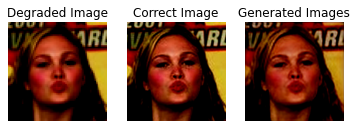

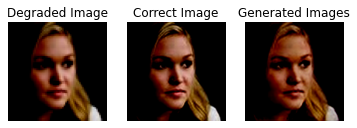

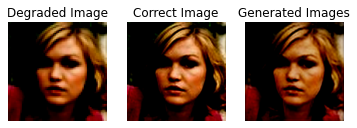

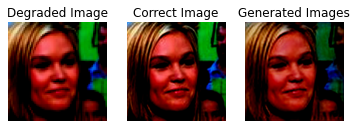

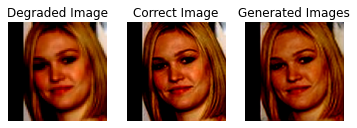

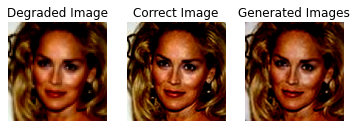

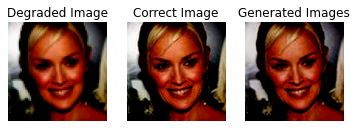

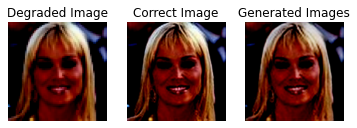

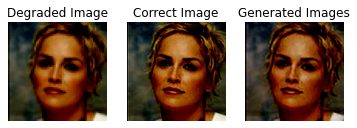

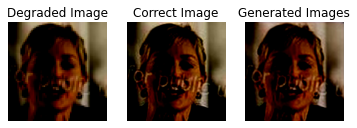

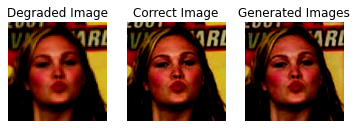

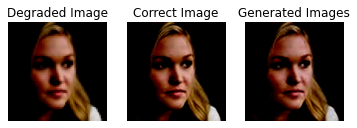

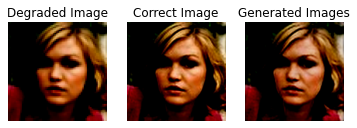

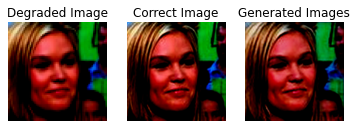

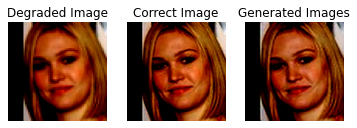

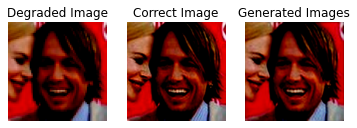

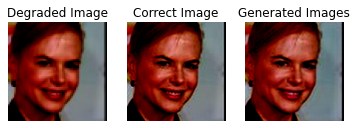

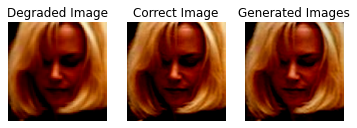

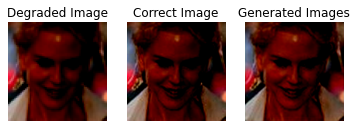

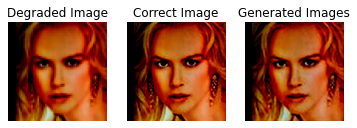

In [ ]:
vgg = build_vgg()
vgg.trainable = False
vgg.compile(loss=get_loss(), optimizer=get_optimizer(), metrics=['accuracy'])

discriminator = build_discriminator()
discriminator.compile(loss=get_loss(), optimizer=get_optimizer(), metrics=['accuracy'])
generator = build_generator()
input_correct = Input(shape=correct_image_shape)
input_degraded = Input(shape=degraded_image_shape)

generated_degraded_images = generator(input_degraded)

features = vgg(generated_degraded_images)

discriminator.trainable = False

probs = discriminator(generated_degraded_images)

adversarial_model = Model([input_degraded, input_correct], [probs, features])
adversarial_model.compile(loss=get_loss(), loss_weights=[1e-3, 1], optimizer=get_optimizer())


for epoch in range(1,epochs):
    print("Epoch:{}".format(epoch))
    correct_images, degraded_images = sample_images(data_dir=data_dir, batch_size=batch_size,
                                                                  degraded_image_shape=degraded_image_shape,
                                                                  correct_image_shape=correct_image_shape)
    print("Checkpoint")

    correct_images = correct_images / 127.5 - 1.
    degraded_images = degraded_images / 127.5 - 1.

    generated_degraded_images = generator.predict(degraded_images)
    real_labels = np.ones((batch_size, 16, 16, 1))
    fake_labels = np.zeros((batch_size, 16, 16, 1))
    d_loss_real = discriminator.train_on_batch(correct_images, real_labels)
    print(generated_degraded_images.shape)
    d_loss_fake = discriminator.train_on_batch(generated_degraded_images, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    print("d_loss:", d_loss)

    """
    Train the generator network
    """

    correct_images, degraded_images = sample_images(data_dir=data_dir, batch_size=batch_size,
                                                                  degraded_image_shape=degraded_image_shape,
                                                                  correct_image_shape=correct_image_shape)

    correct_images = correct_images / 127.5 - 1.
    degraded_images = degraded_images / 127.5 - 1.
    image_features = vgg.predict(correct_images)

    g_loss = adversarial_model.train_on_batch([degraded_images, correct_images],
                                      [real_labels, image_features])
    print("g_loss:", g_loss)


    if epoch % 500 == 0:
        correct_images, degraded_images = sample_images(data_dir=data_dir, batch_size=batch_size,
                                                                      degraded_image_shape=degraded_image_shape,
                                                                      correct_image_shape=correct_image_shape)
        correct_images = correct_images / 127.5 - 1.
        degraded_images = degraded_images / 127.5 - 1.
        generated_images = generator.predict_on_batch(degraded_images)
        for index, img in enumerate(generated_images):
            save_images(degraded_images[index], correct_images[index], img,
                        path="results/img_{}_{}".format(epoch, index))

# Save models
        generator.save_weights("generator__{}_{}.h5".format(str(epoch),str(index)))
        discriminator.save_weights("discriminator__{}_{}.h5".format(str(epoch),str(index)))

## Evaluation

In [ ]:
def view_images(low_resolution_image, original_image, generated_image):
    fig = plt.figure(figsize=(14,14))
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(low_resolution_image)
    ax.axis("off")
    ax.set_title("Degraded Image")

    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(original_image)
    ax.axis("off")
    ax.set_title("Correct Image")

    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(generated_image)
    ax.axis("off")
    ax.set_title("Generated Images")


In [ ]:
def inference_data(data_dir, NUM_DISPLAY ):

    degraded_images = []
    correct_images = []

    all_dir = os.listdir(data_dir + "correct/test/")

    for i in range(NUM_DISPLAY):
      i = random.choice(all_dir)
      correct_data_dir = data_dir + "correct/test/"+i
      degraded_data_dir = data_dir  + "degraded/test/" + i
      all_images = os.listdir(correct_data_dir)
      image = random.choice(all_images)

      print(correct_data_dir+'/'+ image)
      sample_correct = imread(correct_data_dir+'/'+ image, mode='RGB').astype(np.float32)
      sample_correct = skimage.transform.resize(sample_correct, correct_image_shape)
      correct_images.append(sample_correct)


      print(degraded_data_dir+'/'+ image)
      sample_degraded = imread(degraded_data_dir +'/' +  image, mode='RGB').astype(np.float32)
      sample_degraded = skimage.transform.resize(sample_degraded,degraded_image_shape)
      degraded_images.append(sample_degraded)

    # Convert the lists to Numpy NDArrays
    return np.array(correct_images), np.array(degraded_images)

In [ ]:
def fix(data):
  discriminator = build_discriminator()
  discriminator.compile(loss=get_loss(), optimizer=get_optimizer(), metrics=['accuracy'])
  generator = build_generator()
  discriminator.load_weights("discriminator__2000_4.h5")
  generator.load_weights("generator__2000_4.h5")

  correct_images, degraded_images = inference_data(data_dir=data, NUM_DISPLAY=NUM_DISPLAY)
  correct_images = correct_images / 127.5 - 1.
  degraded_images = degraded_images / 127.5 - 1.  
  generated_images = generator.predict_on_batch(degraded_images)

  for index, img in enumerate(generated_images):
      view_images(degraded_images[index], correct_images[index], img)

# Results
Run this block after done to look at some of the results of the fix function yourself.

/content/pubfig831/correct/test/David Beckham/test__000022-000007.jpg
/content/pubfig831/degraded/test/David Beckham/test__000022-000007.jpg
/content/pubfig831/correct/test/Zac Efron/test__000083-000035.jpg
/content/pubfig831/degraded/test/Zac Efron/test__000083-000035.jpg
/content/pubfig831/correct/test/Cristiano Ronaldo/test__000019-000040.jpg
/content/pubfig831/degraded/test/Cristiano Ronaldo/test__000019-000040.jpg
/content/pubfig831/correct/test/Colin Powell/test__000018-000029.jpg
/content/pubfig831/degraded/test/Colin Powell/test__000018-000029.jpg
/content/pubfig831/correct/test/Kate Winslet/test__000048-000003.jpg
/content/pubfig831/degraded/test/Kate Winslet/test__000048-000003.jpg
/content/pubfig831/correct/test/Michael Bloomberg/test__000059-000002.jpg
/content/pubfig831/degraded/test/Michael Bloomberg/test__000059-000002.jpg
/content/pubfig831/correct/test/Kate Winslet/test__000048-000040.jpg
/content/pubfig831/degraded/test/Kate Winslet/test__000048-000040.jpg
/content/pu

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

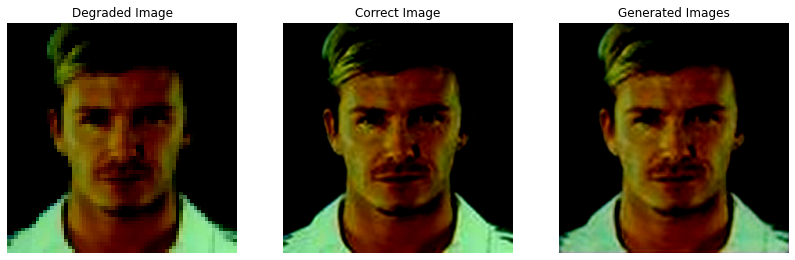

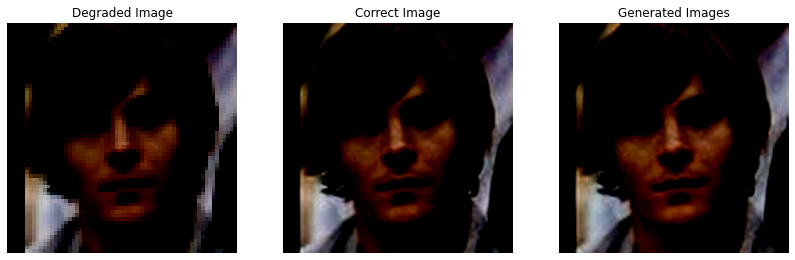

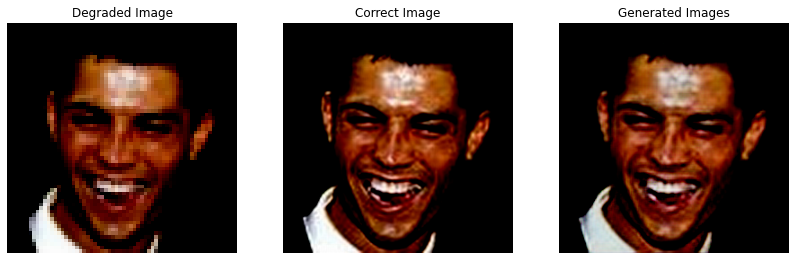

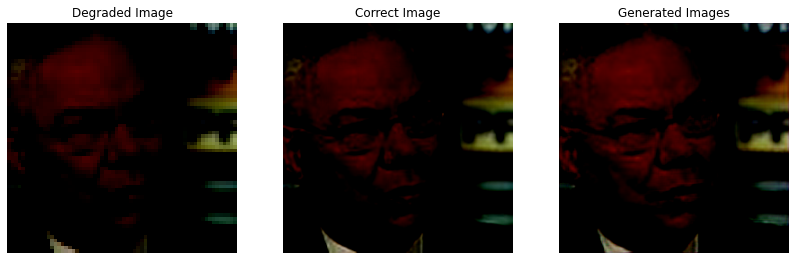

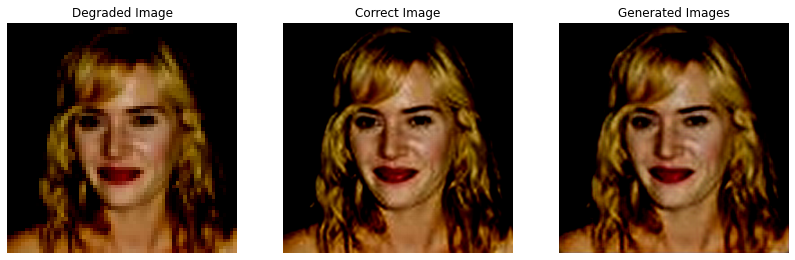

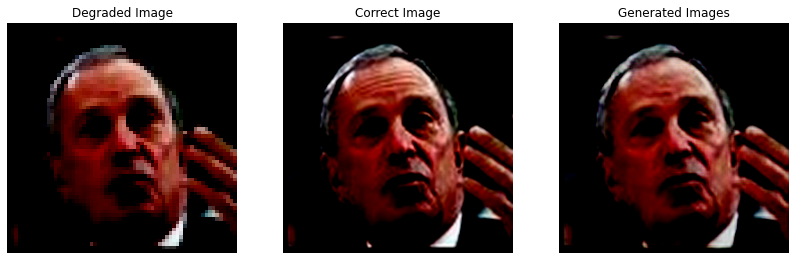

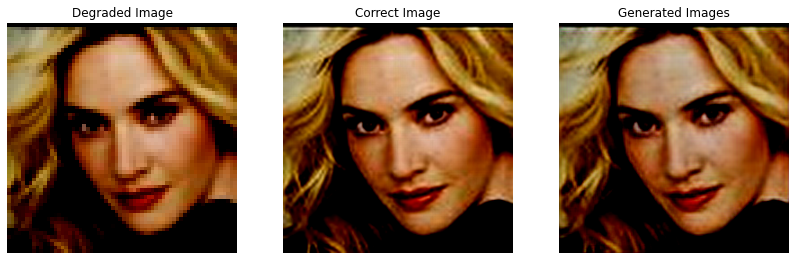

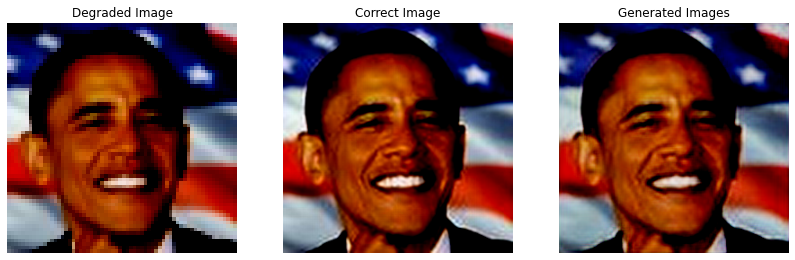

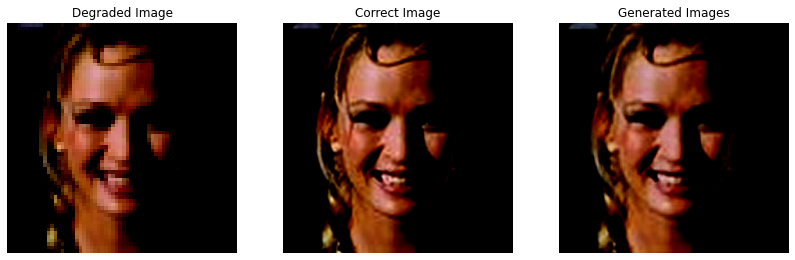

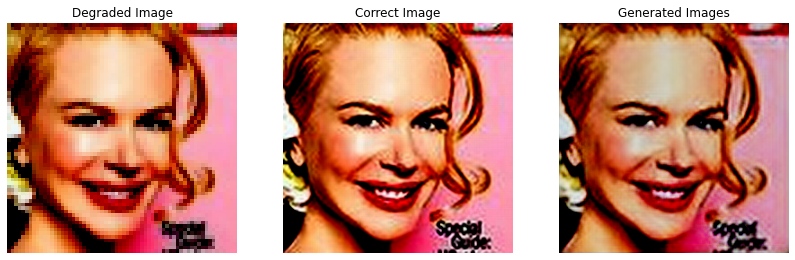

In [ ]:
%matplotlib inline

import os
import random
from glob import glob
import imageio
import cv2 
import matplotlib.pyplot as plt
import numpy as np
import skimage
import warnings
warnings.filterwarnings('ignore')
NUM_DISPLAY = 10
data = '/content/pubfig831/'
fix(data)


In [ ]:
%matplotlib inline

import os
import random
from glob import glob

import cv2
import matplotlib.pyplot as plt
import numpy as np

NUM_DISPLAY = 5

files = glob('/content/pubfig831/correct/test/*/*')
grid = []

for path in random.sample(files, NUM_DISPLAY):
  correct = cv2.imread(path)
  split = path.split('/')
  degraded = cv2.imread('/'.join([*split[:3], 'degraded', *split[4:]]))
  fixed = fix(degraded)
  grid.append(np.column_stack([degraded, fixed, correct]))

image = np.row_stack(grid)
dpi = float(plt.rcParams['figure.dpi'])
figsize = image.shape[1] / dpi, image.shape[0] / dpi
ax = plt.figure(figsize=figsize).add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(image[..., ::-1])
plt.show()

UFuncTypeError: ignored